# One Table To Rule Them All: Radio

This notebook generates a table of radio components in the CDFS and ELAIS-S1 fields, according to various incarnations of the ATLAS survey. To run it, you will need a MongoDB server with the RGZ database loaded. All other data is fetched from the internet.

In the following cell, specify the MongoDB server details:

In [2]:
MONGO_HOST = 'localhost'
MONGO_PORT = 27017

In this cell, specify if you have access to a crowdastro output file (crowdastro.h5), and if so, where it is:

In [3]:
USING_CROWDASTRO = True
CROWDASTRO_PATH = 'crowdastro-swire.h5'
# To get this file, run `crowdastro import_data --ir swire`.

In this cell, specify if you have access to a CSV of the Fan et al. (2015) cross-identifications, and if so, where it is:

In [4]:
USING_FAN = True
FAN_PATH = 'fan_2015_a.csv'

In this cell, specify if you have access to the 11 January 2014 Franzen catalogue, and if so, where it is:

In [5]:
USING_FRANZEN = True
FRANZEN_PATH = 'ATLASDR3_CDFS_cmpcat_11JAN2014.dat'

Next, we will fetch the resources we need.

In [6]:
NORRIS_COMPONENTS_URI = 'http://www.atnf.csiro.au/people/rnorris/papers/n202/tab4.txt'
NORRIS_CROSS_IDENTIFICATIONS_URI = 'http://www.atnf.csiro.au/people/rnorris/papers/n202/tab6.txt'
MIDDELBERG_COMPONENTS_URI = 'http://iopscience.iop.org/article/10.1086/508275/fulltext/datafile4.txt'
MIDDELBERG_CROSS_IDENTIFICATIONS_URI = 'http://iopscience.iop.org/article/10.1086/508275/fulltext/datafile6.txt'

In [7]:
# Load Norris components.
import requests, io, astropy.io.ascii as asc, astropy.table, pandas
norris_components = astropy.table.Table.from_pandas(
    pandas.read_fwf(
        io.StringIO(
            requests.get(NORRIS_COMPONENTS_URI).text
        ),
        skiprows=[0, 2],
        header=0,
        widths=map(len, [
                '   # ',
                'Name                       ',
                'Radio RA     ',
                'Radio dec  ',
                'err(RA) ',
                'err(dec) ',
                'Peak Flux  ',
                'Int flux   ',
                'Bmaj   ',
                'Bmin   ',
                ' Bpa      ',
                ' rms  ',
            ])
    )
)
norris_components

#,Name,Radio RA,Radio dec,err(RA),err(dec),Peak Flux,Int flux,Bmaj,Bmin,Bpa,rms
str4,str26,str11,str11,float64,float64,float64,float64,float64,float64,float64,float64
C001,ATCDFS_J032602.78-284709.0,3:26:02.785,-28:47:09.0,0.78,0.73,0.7,1.38,8.3,2.6,60.8,79.3
C002,ATCDFS_J032604.15-275659.3,3:26:04.152,-27:56:59.3,0.55,0.9,0.71,1.97,11.5,7.3,-17.0,71.9
C003,ATCDFS_J032605.68-274734.4,3:26:05.685,-27:47:34.4,0.1,0.11,40.81,74.7,5.9,5.6,85.7,119.1
C004,ATCDFS_J032606.95-275332.2,3:26:06.955,-27:53:32.2,0.52,1.19,0.41,0.43,0.0,0.0,-1.0,76.7
C005,ATCDFS_J032611.47-273243.8,3:26:11.475,-27:32:43.8,0.1,0.1,69.65,110.9,5.3,3.3,89.6,156.3
C006,ATCDFS_J032613.70-281717.7,3:26:13.701,-28:17:17.7,0.57,0.79,0.48,0.54,0.0,0.0,0.0,77.7
C007,ATCDFS_J032615.48-284629.2,3:26:15.489,-28:46:29.2,0.34,0.36,0.45,0.71,0.0,0.0,0.0,66.0
C008,ATCDFS_J032615.55-280601.0,3:26:15.557,-28:06:01.0,0.3,0.47,0.73,1.06,0.0,0.0,-1.0,56.9
C009,ATCDFS_J032616.35-280014.6,3:26:16.353,-28:00:14.6,0.18,0.3,1.24,1.66,0.0,0.0,-1.0,60.1


In [8]:
# Load Norris cross-identifications.
# This table has inconsistent tabs, so we will have to convert them to "soft tabs".
def replace_tabs(s, tabstop=8):
    """Convert tabs to spaces."""
    out = ''
    upto = 0
    last = None
    for c in s:
        if c == '\t':
            # Fill up to next tabstop.
            diff = tabstop - upto % tabstop
            if diff == 0:
                diff = tabstop
            out += ' ' * diff
            upto += diff
            last = c
            continue
        
        last = c
        out += c
        upto += 1

    return out

test_input = ('S001	ATCDFS_J032602.78-284709.0	C001	            SWIRE3_J032603.15-284708.5	3:26:02.785	-28:47:09.06	1.4	33.8	21.1	-1.0	-1.0	-1.0						 	4					looks like a group in irac 1')
test_output = ('S001    ATCDFS_J032602.78-284709.0      C001                SWIRE3_J032603.15-284708.5  3:26:02.785     -28:47:09.06    1.4     33.8    21.1    -1.0    -1.0    -1.0                                                    4                                       looks like a group in irac 1')

assert test_output == replace_tabs(test_input)


norris_cross_identifications = astropy.table.Table.from_pandas(
    pandas.read_fwf(
        io.StringIO(
            '\n'.join(map(
                    lambda s: replace_tabs(s, 8),
                    requests.get(NORRIS_CROSS_IDENTIFICATIONS_URI).text.split('\r\n'))
             )
        ),
        skiprows=[0, 2],
        header=0,
        widths=[8, 32, 20, 28, 16, 16, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16, 8, 16]
    )
)
norris_cross_identifications[700:710]

#,Name,Component,SWIRE,Radio RA,Radio dec,20cm,3.6µm,4.5µm,5.8µm,8.0µm,24µm,U,G,R,I,Z,z(sp),ID,Class,Basis
str4,str26,str19,str26,str11,str12,float64,float64,str8,str8,str8,float64,float64,float64,float64,float64,float64,float64,int64,str4,str3
S701,ATCDFS_J033529.42-285156.5,C753,SWIRE3_J033529.46-285154.5,3:35:29.424,-28:51:56.54,1.7,716.0,521.4,194.3,146.7,-1.0,20.6,18.8,17.5,16.7,16.4,--,3,--,--
S702,ATCDFS_J033530.22-281108.4,C754,SWIRE3_J033530.19-281108.5,3:35:30.229,-28:11:08.45,0.8,32.2,38.5,-1.0,56.2,376.3,99.0,99.0,99.0,99.0,99.0,--,1,AGN,b
S703,ATCDFS_J033531.02-272702.2,C755,--,3:35:31.025,-27:27:02.20,26.1,--,--,--,--,--,--,--,--,--,--,--,9,--,--
S704,ATCDFS_J033532.11-274547.6,C756,SWIRE3_J033532.11-274545.2,3:35:32.115,-27:45:47.61,2.2,164.4,84.6,55.3,40.6,-1.0,--,--,--,--,--,--,3,--,--
S705,ATCDFS_J033532.19-284801.0,C757,SWIRE3_J033532.19-284801.1,3:35:32.192,-28:48:01.08,0.9,222.5,417.8,1084.8,2999.4,10830.1,99.0,24.2,22.0,20.7,20.1,--,1,--,--
S706,ATCDFS_J033533.22-280621.8,C758,--,3:35:33.224,-28:06:21.85,0.3,--,--,--,--,--,--,--,--,--,--,--,9,--,--
S707,ATCDFS_J033533.96-273313.4,"C759,C760,C761,C764",SWIRE3_J033533.90-273310.9,3:35:33.963,-27:33:13.46,9.4,451.6,512.5,724.7,966.6,2208.2,--,19.8,19.5,18.9,--,--,3,AGN,b
S708,ATCDFS_J033534.47-284213.3,C763,SWIRE3_J033534.66-284221.7,3:35:34.479,-28:42:13.31,0.5,79.8,53.1,-1.0,44.3,-1.0,99.0,22.7,21.3,20.4,19.9,--,4,--,--
S709,ATCDFS_J033535.20-281729.0,"C762,C765",SWIRE3_J033535.20-281729.0,3:35:35.20,-28:17:29.00,8.4,34.5,25.3,-1.0,-1.0,-1.0,99.0,99.0,99.0,22.6,21.9,--,-1,AGN,a


In [9]:
# Load Middelberg tables.
middelberg_components = asc.read(MIDDELBERG_COMPONENTS_URI)
print(middelberg_components[0])
middelberg_cross_identifications = asc.read(MIDDELBERG_CROSS_IDENTIFICATIONS_URI)
print(middelberg_cross_identifications[0])

 ID             Name            RAh RAm  RAs  DE- DEd  DEm    DEs   e_RAs  e_DEs  PFlux IFlux MajAxis MinAxis PosAng rms  Com
                                 h  min   s       deg arcmin arcsec arcsec arcsec  mJy   mJy   arcsec  arcsec  deg   uJy     
---- -------------------------- --- --- ----- --- --- ------ ------ ------ ------ ----- ----- ------- ------- ------ ---- ---
C001 ATCDFS_J032602.78-284709.0   3  26 2.785   -  28     47    9.0   0.78   0.73   0.7  1.38     8.3     2.6   60.8 79.3  --
 ID             Name            CID            SName            RAh RAm  RAs  DE- DEd  DEm    DEs   F20 F3.6 F4.5 F5.8 F8.0 F24  umag gmag rmag Imag zmag  z  Type Class f_Class             Comm            
                                                                 h  min   s       deg arcmin arcsec mJy uJy  uJy  uJy  uJy  uJy  mag  mag  mag  mag  mag                                                     
---- -------------------------- ---- -------------------------- --- --- ----- --- --

In [10]:
# Convert Middelberg data into columns. There's no catalogue matching to do here so we can
# throw everything in right away.
import astropy.coordinates

_middelberg_component_ids = middelberg_components['ID']
_middelberg_component_names = middelberg_components['Name']
_middelberg_component_positions = [
    astropy.coordinates.SkyCoord(ra=(r['RAh'], r['RAm'], r['RAs']),
                                 dec=(-r['DEd'], r['DEm'], r['DEs']),
                                 unit=('hourangle', 'deg'))
    for r in middelberg_components
]
_middelberg_component_ras = [r.ra.deg for r in _middelberg_component_positions]
_middelberg_component_decs = [r.dec.deg for r in _middelberg_component_positions]
_middelberg_component_peak_flux = middelberg_components['PFlux']
_middelberg_component_int_flux = middelberg_components['IFlux']
_middelberg_source_ids = middelberg_components['ID']
_middelberg_cid_to_source_id = {}
_middelberg_cid_to_source_name = {}
_middelberg_cid_to_swire = {}
_middelberg_cid_to_source_z = {}
_middelberg_cid_to_source_ra = {}
_middelberg_cid_to_source_dec = {}
for row in middelberg_cross_identifications:
    for component in row['CID'].split(','):
        component = component.strip()
        _middelberg_cid_to_source_id[component] = row['ID']
        _middelberg_cid_to_source_name[component] = row['Name']
        _middelberg_cid_to_swire[component] = row['SName']
        _middelberg_cid_to_source_z[component] = row['z']
        pos = astropy.coordinates.SkyCoord(ra=(row['RAh'], row['RAm'], row['RAs']),
                                           dec=(-row['DEd'], row['DEm'], row['DEs']),
                                           unit=('hourangle', 'deg'))
        _middelberg_cid_to_source_ra[component] = pos.ra.deg
        _middelberg_cid_to_source_dec[component] = pos.dec.deg

_middelberg_component_source_ids = [_middelberg_cid_to_source_id[c] for c in _middelberg_component_ids]
_middelberg_component_source_names = [_middelberg_cid_to_source_name[c] for c in _middelberg_component_ids]
_middelberg_component_swires = [_middelberg_cid_to_swire[c] for c in _middelberg_component_ids]
_middelberg_component_source_zs = [_middelberg_cid_to_source_z[c] for c in _middelberg_component_ids]
_middelberg_component_source_ras = [_middelberg_cid_to_source_ra[c] for c in _middelberg_component_ids]
_middelberg_component_source_decs = [_middelberg_cid_to_source_dec[c] for c in _middelberg_component_ids]

In [13]:
# Load RGZ.
import pymongo, numpy

client = pymongo.MongoClient(MONGO_HOST, MONGO_PORT)
db = client['radio']

_rgz_sources = []
_rgz_coords = []
_rgz_zids = []

for subject in db.radio_subjects.find({'metadata.survey': 'atlas'}):
    source = subject['metadata']['source']
    ra, dec = subject['coords']
    zid = subject['zooniverse_id']
    _rgz_sources.append(source)
    _rgz_coords.append((ra, dec))
    _rgz_zids.append(zid)

_rgz_coords = numpy.array(_rgz_coords)

In [71]:
# Load consensuses from crowdastro.
import h5py
with h5py.File(CROWDASTRO_PATH, 'r') as crowdastro_h5:
    # (atlas_i, ir_i, success, percentage)
    _crowdastro_consensus_objects = crowdastro_h5['/atlas/cdfs/consensus_objects']
    _crowdastro_zids = [r[0].decode('ascii') for r in crowdastro_h5['/atlas/cdfs/string']]
    _crowdastro_swire_names = [r.decode('ascii') for r in crowdastro_h5['/swire/cdfs/string']]
    _crowdastro_zid_to_swire = {}
    _crowdastro_zid_to_percentages = {}
    _crowdastro_zid_to_fit_success = {}
    for atlas_i, ir_i, success, percentage in _crowdastro_consensus_objects:
        _crowdastro_zid_to_swire[_crowdastro_zids[int(atlas_i)]] = _crowdastro_swire_names[int(ir_i)]
        _crowdastro_zid_to_percentages[_crowdastro_zids[int(atlas_i)]] = percentage
        _crowdastro_zid_to_fit_success[_crowdastro_zids[int(atlas_i)]] = bool(success)

In [15]:
# Load Franzen.
franzen = asc.read(FRANZEN_PATH)
# Note that multi-component Franzen objects are matched to exactly one RGZ object, which is associated with the
# first component of said object. We will not make the same assumption here.
franzen

ID,Name,RA,DEC,RA_ERR,DEC_ERR,SNR,RMS,BWS,Sp,Sp_ERR,S,S_ERR,DECONV,DECONV_ERR,V,OBS_FREQ,SINDEX,INDEX_ERR
str8,str27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
CI0001C1,ATLAS3_J032836.59-284145.1C,52.152477,-28.69587,0.00199,0.00176,23135.61,0.041,0.96,948.56,0.32,984.24,0.34,2.088,0.013,1.0,1472.61,-0.703,0.005
CI0001C2,ATLAS3_J032836.49-284201.1C,52.152059,-28.700312,0.0131,0.00956,4266.59,0.041,0.96,174.93,0.33,200.05,0.38,4.08,0.038,1.0,1472.46,-0.703,0.005
CI0001C3,ATLAS3_J032836.38-284155.0C,52.151573,-28.698618,0.0503,0.0441,924.15,0.041,0.96,37.89,0.27,112.08,0.8,15.066,0.039,1.0,1472.53,-0.703,0.005
CI0001C4,ATLAS3_J032835.99-284104.2C,52.149971,-28.684496,1.071,2.606,15.66,0.041,0.96,0.642,0.199,1.21,0.38,10.127,2.525,0.915,1473.08,-0.703,0.005
CI0001C5,ATLAS3_J032836.77-284148.2C,52.153192,-28.69673,0.114,0.1825,223.66,0.041,0.96,9.17,0.34,28.5,1.1,15.632,0.198,1.0,1472.58,-0.703,0.005
CI0002,ATLAS3_J032734.01-284621.5C,51.89172,-28.772626,0.017,0.035,4819.0,0.031,0.97,153.35,7.819,159.314,7.966,2.123,1.949,1.0,1480.37,-0.233,0.012
CI0003,ATLAS3_J032611.46-273243.0C,51.547764,-27.54529,0.017,0.035,3889.0,0.026,0.95,106.644,5.438,107.635,5.382,1.038,3.988,1.0,1488.15,-0.481,0.014
CI0004,ATLAS3_J033409.28-282420.0C,53.538672,-28.405543,0.017,0.035,3616.0,0.018,0.97,65.128,3.321,75.989,3.799,4.397,0.941,1.0,1493.32,-0.621,0.014
CI0005C1,ATLAS3_J032737.35-280132.8C,51.905615,-28.025772,0.0621,0.0487,447.33,0.015,0.97,6.71,0.42,0.0,0.0,0.0,0.0,1.0,1488.39,-0.474,0.013


In [27]:
# Match Franzen to Norris.
import scipy.spatial
_franzen_cid_to_norris = {}  # Maps Franzen CID -> Norris CID (RGZ uses Franzen CIDs)
_norris_cids = [r['#'] for r in norris_components]
_norris_coords = [astropy.coordinates.SkyCoord(
    ra=r['Radio RA'],
    dec=r['Radio dec'],
    unit=('hourangle', 'deg')) for r in norris_components]

_norris_coords = numpy.array([(p.ra.deg, p.dec.deg) for p in _norris_coords])
_norris_tree = scipy.spatial.KDTree(_norris_coords)
_franzen_coords = numpy.array(list(zip([franzen['RA'], franzen['DEC']])))[:, 0, :].T
_franzen_cids = franzen['ID']
_dists, _indices = _norris_tree.query(_franzen_coords)
_matches = _dists < 5 / 60 / 60

for cid, match, index in zip(_franzen_cids, _matches, _indices):
    if not match:
        continue
    
    _franzen_cid_to_norris[cid] = _norris_cids[index]
_norris_to_franzen_cid = {j:i for i, j in _franzen_cid_to_norris.items()}

In [21]:
# Load Fan.
fan_cross_identifications = asc.read(FAN_PATH, header_start=0, delimiter=',')
_fan_source_ids = fan_cross_identifications['id']
_fan_id_to_swire = {r['id']:r['swire'] for r in fan_cross_identifications}
# Assuming that CID in Fan = CID in Norris.
_fan_component_to_source = {}
_fan_component_to_swire = {}
for row in fan_cross_identifications:
    components = row['radios'].split(',')
    for component in components:
        component = component.strip()
        _fan_component_to_source[component] = row['id']
        _fan_component_to_swire[component] = row['swire']

Now, we can construct the table. We will have the following columns:

- Key
- [component columns in Norris] (Norris)
- [source columns in Norris] (Norris)
- Source ID (Fan)
- SWIRE Name (Fan)
- [component columns in Franzen] (Franzen)
- Component ID (RGZ)
- Zooniverse ID (RGZ)
- SWIRE Name (RGZ-MV)
- Gaussian Click Fit Success (RGZ)
- Click Agreement (RGZ)

<!--
- Component ID (Middelberg)
- Component Name (Middelberg)
- RA (Middelberg)
- Dec (Middelberg)
- Source ID (Middelberg)
- Source Name (Middelberg)
- SWIRE Name (Middelberg)
- Peak Flux (Middelberg)
- Int Flux (Middelberg)
- Source RA (Middelberg)
- Source Dec (Middelberg)
- Source Redshift (Middelberg)
-->

In [72]:
names = ['Key'] + [
    'Component ' + k + ' (Norris)' for k in norris_components.columns.keys()] + [
    'Source ' + k + ' (Norris)' for k in norris_cross_identifications.columns.keys()] + [
    'Source # (Fan)',
    'Source SWIRE Name (Fan)'] + [
    'Component ' + k + ' (Franzen)' for k in franzen.columns.keys()] + [
    'Component Zooniverse ID (RGZ)',
    'Primary Component ID (RGZ)',
    'Source SWIRE Name (RGZ)',
    'Gaussian Click Fit Success (RGZ)',
    'Click Agreement (RGZ)']

names

['Key',
 'Component # (Norris)',
 'Component Name (Norris)',
 'Component Radio RA (Norris)',
 'Component Radio dec (Norris)',
 'Component err(RA) (Norris)',
 'Component err(dec) (Norris)',
 'Component Peak Flux (Norris)',
 'Component Int flux (Norris)',
 'Component Bmaj (Norris)',
 'Component Bmin (Norris)',
 'Component Bpa (Norris)',
 'Component rms (Norris)',
 'Source # (Norris)',
 'Source Name (Norris)',
 'Source Component (Norris)',
 'Source SWIRE (Norris)',
 'Source Radio RA (Norris)',
 'Source Radio dec (Norris)',
 'Source 20cm (Norris)',
 'Source 3.6µm (Norris)',
 'Source 4.5µm (Norris)',
 'Source 5.8µm (Norris)',
 'Source 8.0µm (Norris)',
 'Source 24µm (Norris)',
 'Source U (Norris)',
 'Source G (Norris)',
 'Source R (Norris)',
 'Source I (Norris)',
 'Source Z (Norris)',
 'Source z(sp) (Norris)',
 'Source ID (Norris)',
 'Source Class (Norris)',
 'Source Basis (Norris)',
 'Source # (Fan)',
 'Source SWIRE Name (Fan)',
 'Component ID (Franzen)',
 'Component Name (Franzen)',
 'Comp

In [91]:
import astropy.table

# Component (Norris)
comp_columns = []
for column in norris_components.columns:
    comp_columns.append(list(norris_components[column]))

# Source (Norris)
source_columns = []
for column in norris_cross_identifications.columns:
    _component_to_value = {}
    for row in norris_cross_identifications:
        components = row['Component'].split(',')
        for component in components:
            component = component.strip()
            _component_to_value[component] = row[column]
    
    column = []
    for component in comp_columns[0]:
        column.append(_component_to_value[component])
    source_columns.append(column)

# Add in the Fan matches.
fan_sources = [_fan_component_to_source.get(c, '') for c in comp_columns[0]]
fan_swires = [_fan_component_to_swire.get(c, '') for c in comp_columns[0]]
fan_columns = [fan_sources, fan_swires]

# Add in the Franzen matches.
franzen_columns = []
for column in franzen.columns:
    _component_to_value = {}
    for row in franzen:
        component = row['ID']
        _component_to_value[component] = row[column]
    
    column = []
    for norris_cid in norris_components['#']:
        if norris_cid not in _norris_to_franzen_cid:
            column.append(float('nan'))
        else:
            franzen_cid = _norris_to_franzen_cid[norris_cid]
            column.append(_component_to_value[franzen_cid])
    franzen_columns.append(column)

# Add in all the Franzen objects with no corresponding Norris.
_all_franzen_ids = set(franzen['ID'])
_included_franzen_ids = {i for i in franzen_columns[0] if isinstance(i, str)}
assert 700 < len(_included_franzen_ids) < 800  # Sanity check.
_missing_franzen_ids = _all_franzen_ids - _included_franzen_ids
# Pad existing columns to include new datapoints.
for column in itertools.chain(comp_columns, source_columns, fan_columns):
    column.extend([float('nan')] * len(_missing_franzen_ids))
# Fill in the Franzen columns.
for row in franzen:
    if row['ID'] in _missing_franzen_ids:
        for column, column_name in zip(franzen_columns, franzen.columns):
            column.append(row[column_name])

# Add in the RGZ data.
# Columns: Zooniverse ID, Primary Component ID, SWIRE Name, Gaussian Click Fit Success,
#          Click Agreement.
# RGZ is a proper subset of Franzen, so all objects in RGZ should already be in the table.
# For multi-component radio objects like CI0001C1..CI0001C5, there is only one RGZ object,
# and it is associated with the first component. Each component here should be associated
# with the same Zooniverse ID, Component ID, and SWIRE Name. The component ID will be the
# ID of the primary component.
_cid_to_zid = dict(zip(_rgz_sources, _rgz_zids))
zooniverse_ids = []
rgz_primary_components = []
rgz_swire_names = []
rgz_successes = []
rgz_percentages = []
import re
for cid in franzen_columns[0]:
    if not cid or not isinstance(cid, str):
        zooniverse_ids.append('')
        rgz_primary_components.append('')
        rgz_swire_names.append('')
        rgz_successes.append('')
        rgz_percentages.append('')
        continue
    multi_component = re.match(r'(CI\d+)C\d+', cid)
    if multi_component:
        primary = multi_component.group(1) + 'C1'
    else:
        primary = cid
    if primary not in _cid_to_zid:
        zooniverse_ids.append('')
        rgz_primary_components.append('')
        rgz_swire_names.append('')
        rgz_successes.append('')
        rgz_percentages.append('')
        continue
    rgz_primary_components.append(primary)
    zooniverse_ids.append(_cid_to_zid[primary])
    rgz_swire_names.append(_crowdastro_zid_to_swire.get(_cid_to_zid[primary], ''))
    rgz_successes.append(_crowdastro_zid_to_fit_success.get(_cid_to_zid[primary], ''))
    rgz_percentages.append(_crowdastro_zid_to_percentages.get(_cid_to_zid[primary], ''))
# Check that all RGZ objects are in the table.
assert all(z in zooniverse_ids for z in _rgz_zids)
assert all(c in zooniverse_ids for c in _crowdastro_zid_to_swire)
rgz_columns = [zooniverse_ids, rgz_primary_components, rgz_swire_names, rgz_successes, rgz_percentages]

# Key
keys = list(range(len(comp_columns[0])))

# Assemble the table data.
data = [keys] + comp_columns + source_columns + fan_columns + franzen_columns + rgz_columns

# Mask everything that is NaN or empty.
for i, column in enumerate(data):
    column = numpy.array(column)
    try:
        masked = numpy.ma.MaskedArray(data=column,
                                      mask=numpy.logical_or(numpy.isnan(column), column == -99.0))
    except TypeError:
        masked = numpy.ma.MaskedArray(data=column,
                                      mask=numpy.logical_or(column == '', column == 'nan'))
    data[i] = masked

# Assemble the whole table.
table = astropy.table.Table(data=data,
                            names=names)
table

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:112: UserWarning: Warning: converting a masked element to nan.


Key,Component # (Norris),Component Name (Norris),Component Radio RA (Norris),Component Radio dec (Norris),Component err(RA) (Norris),Component err(dec) (Norris),Component Peak Flux (Norris),Component Int flux (Norris),Component Bmaj (Norris),Component Bmin (Norris),Component Bpa (Norris),Component rms (Norris),Source # (Norris),Source Name (Norris),Source Component (Norris),Source SWIRE (Norris),Source Radio RA (Norris),Source Radio dec (Norris),Source 20cm (Norris),Source 3.6µm (Norris),Source 4.5µm (Norris),Source 5.8µm (Norris),Source 8.0µm (Norris),Source 24µm (Norris),Source U (Norris),Source G (Norris),Source R (Norris),Source I (Norris),Source Z (Norris),Source z(sp) (Norris),Source ID (Norris),Source Class (Norris),Source Basis (Norris),Source # (Fan),Source SWIRE Name (Fan),Component ID (Franzen),Component Name (Franzen),Component RA (Franzen),Component DEC (Franzen),Component RA_ERR (Franzen),Component DEC_ERR (Franzen),Component SNR (Franzen),Component RMS (Franzen),Component BWS (Franzen),Component Sp (Franzen),Component Sp_ERR (Franzen),Component S (Franzen),Component S_ERR (Franzen),Component DECONV (Franzen),Component DECONV_ERR (Franzen),Component V (Franzen),Component OBS_FREQ (Franzen),Component SINDEX (Franzen),Component INDEX_ERR (Franzen),Component Zooniverse ID (RGZ),Primary Component ID (RGZ),Source SWIRE Name (RGZ),Gaussian Click Fit Success (RGZ),Click Agreement (RGZ)
int64,str4,str26,str11,str11,float64,float64,float64,float64,float64,float64,float64,float64,str4,str26,str19,str32,str11,str12,float64,float64,str32,str32,str32,float64,float64,float64,float64,float64,float64,float64,float64,str32,str32,str5,str26,str8,str27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10,str8,str26,str5,str32
0,C001,ATCDFS_J032602.78-284709.0,3:26:02.785,-28:47:09.0,0.78,0.73,0.7,1.38,8.3,2.6,60.8,79.3,S001,ATCDFS_J032602.78-284709.0,C001,SWIRE3_J032603.15-284708.5,3:26:02.785,-28:47:09.06,1.4,33.8,21.1,-1.0,-1.0,-1.0,--,--,--,--,--,--,4.0,--,--,91,SWIRE3_J032603.15-284708.5,CI0412,ATLAS3_J032602.82-284708.1C,51.511734,-28.785575,0.171,0.414,29.0,0.045,0.93,1.395,0.086,2.211,0.119,8.234,0.576,0.995,1450.89,--,--,ARG0003rb2,CI0412,SWIRE3_J032602.36-284711.5,True,1.0
1,C002,ATCDFS_J032604.15-275659.3,3:26:04.152,-27:56:59.3,0.55,0.9,0.71,1.97,11.5,7.3,-17.0,71.9,S002,ATCDFS_J032604.15-275659.3,C002,--,3:26:04.152,-27:56:59.39,2.0,--,--,--,--,--,--,--,--,--,--,--,8.0,--,--,--,--,CI0354,ATLAS3_J032604.21-275659.6C,51.517555,-27.949875,0.141,0.342,35.25,0.036,0.93,1.35,0.079,1.826,0.098,6.393,0.72,0.994,1449.61,--,--,--,--,--,--,--
2,C003,ATCDFS_J032605.68-274734.4,3:26:05.685,-27:47:34.4,0.1,0.11,40.81,74.7,5.9,5.6,85.7,119.1,S003,ATCDFS_J032605.68-274734.4,C003,--,3:26:05.685,-27:47:34.48,74.7,--,--,--,--,--,--,--,--,--,--,--,8.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
3,C004,ATCDFS_J032606.95-275332.2,3:26:06.955,-27:53:32.2,0.52,1.19,0.41,0.43,0.0,0.0,-1.0,76.7,S004,ATCDFS_J032606.95-275332.2,C004,--,3:26:06.955,-27:53:32.26,0.4,--,--,--,--,--,--,--,--,--,--,--,8.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
4,C005,ATCDFS_J032611.47-273243.8,3:26:11.475,-27:32:43.8,0.1,0.1,69.65,110.9,5.3,3.3,89.6,156.3,S005,ATCDFS_J032611.47-273243.8,C005,--,3:26:11.475,-27:32:43.81,110.9,--,--,--,--,--,--,--,--,--,--,--,8.0,--,--,--,--,CI0003,ATLAS3_J032611.46-273243.0C,51.547764,-27.54529,0.017,0.035,3889.0,0.026,0.95,106.644,5.438,107.635,5.382,1.038,3.988,1.0,1488.15,-0.481,0.014,--,--,--,--,--
5,C006,ATCDFS_J032613.70-281717.7,3:26:13.701,-28:17:17.7,0.57,0.79,0.48,0.54,0.0,0.0,0.0,77.7,S006,ATCDFS_J032613.70-281717.7,C006,(441298),3:26:13.701,-28:17:17.71,0.5,6.4,-1.0,-1.0,-1.0,-1.0,--,--,--,--,--,--,3.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
6,C007,ATCDFS_J032615.48-284629.2,3:26:15.489,-28:46:29.2,0.34,0.36,0.

In [92]:
table.write('one-table-to-rule-them-all.tbl', format='csv')

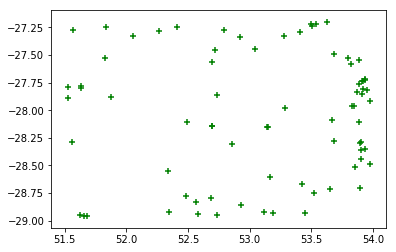

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
def decimalify(ras, decs):
    from astropy.coordinates import SkyCoord
    coords = []
    for ra, dec in zip(ras, decs):
        sc = SkyCoord(ra=ra, dec=dec, unit=('hourangle', 'deg'))
        coords.append((sc.ra.deg, sc.dec.deg))
    return zip(*coords)
not_in_franzen = table[[not bool(i) for i in table['Component ID (Franzen)']]]
ras = not_in_franzen['Component Radio RA (Norris)']
decs = not_in_franzen['Component Radio dec (Norris)']
plt.scatter(*decimalify(ras, decs), color='green', marker='+')
plt.show()